In [1]:
import pandas as pd
import numpy as np
import sys
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt
#from sklearn.model_selection import train_test_split
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from PIL import Image
from torchvision import transforms
from sklearn.metrics import jaccard_score
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import torchvision.models.segmentation as models
import torchmetrics

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()

True

In [3]:
torch.cuda.memory_allocated()

0

In [4]:
train_df = pd.read_pickle(r'/kaggle/input/lung-cancer-ct-slices/lung_cancer_train.pkl')
test_df = pd.read_pickle(r'/kaggle/input/lung-cancer-ct-slices/lung_cancer_test.pkl')

In [5]:
class CustomDataset(Dataset):
    def __init__(self, images, masks, transforms=None):
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __getitem__(self, index):
        image = self.images[index]  # Directly access the NumPy array
        image = np.asarray(image).astype('uint8')#.reshape(512, 512, 1)
        
        mask = self.masks[index]
        mask = np.asarray(mask).astype('uint8')#.reshape(512, 512, 1)

        transformed_image = self.transforms(image)
        return transformed_image, mask

    def __len__(self):
        return len(self.images)

transform = transforms.Compose([
    transforms.ToPILImage(),
    #transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_images = (train_df['hu_array_old'].values)
train_masks = (train_df['mask'].values)
test_images = (test_df['hu_array_old'].values)
test_masks = (test_df['mask'].values)

train_data = CustomDataset(train_images, train_masks, transform)
trainloader = DataLoader(train_data, batch_size=12, shuffle=False)

test_data = CustomDataset(test_images, test_masks, transform)
testloader = DataLoader(test_data, batch_size=12, shuffle=False)


In [ ]:
# Load the pre-trained DeepLabV3 model
model = models.deeplabv3_resnet50(pretrained=True)

# Modify the classifier and aux_classifier layers
in_channels = 1  # Grayscale input
out_channels = 1  # Single-channel output (binary segmentation)

model.classifier[4] = torch.nn.Conv2d(256, out_channels, kernel_size=(1, 1), stride=(1, 1))
model.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.aux_classifier[4] = torch.nn.Conv2d(256, out_channels, kernel_size=(1, 1), stride=(1, 1))

model.cuda()


In [7]:
# Loss function (Dice loss)
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        intersection = torch.sum(inputs * targets)
        union = torch.sum(inputs) + torch.sum(targets) + self.smooth
        dice = (2.0 * intersection + self.smooth) / union
        return 1.0 - dice

criterion = DiceLoss()

In [8]:
def calculate_sensitivity(predicted_masks, ground_truth_masks):
    # Convert predictions to binary (0 or 1)
    predicted_masks_binary = (predicted_masks > 0.5).float()
    ground_truth_masks_binary = (ground_truth_masks > 0.5).float()

    # Calculate true positives and false negatives
    true_positives = (predicted_masks_binary * ground_truth_masks_binary).sum().item()
    false_negatives = ((1 - predicted_masks_binary) * ground_truth_masks_binary).sum().item()

    # Compute sensitivity (recall)
    sensitivity = true_positives / (true_positives + false_negatives)
    return sensitivity




In [9]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Initialize lists to store metrics
train_recalls, train_accuracies, train_precisions = [], [], []

total_val_loss = 0

train_dice_loss, test_dice_loss = [], []
train_accuracy, test_accuracy = [], []
train_sensitivity, test_sensitivity = [], []
nepochs = []


# Train the model
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_predicted_masks = []
test_predicted_masks = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    nepochs.append(epoch+1)
    model.train()  # Set the model to training mode
    
    total_loss = 0
    i = 0
    sensitivity = 0

    for batch in trainloader:
        correct_pixels = 0
        total_pixels = 0
        i+=1
        inputs, masks = batch
        inputs, masks = inputs.cuda(), masks.cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        predict = outputs["out"]
        outputs = outputs["out"].squeeze(1)  # Remove channel dimension
        

        # Convert predictions to binary (0 or 1)
        predicted_masks = (outputs > 0.5).float()
        

        train_predicted_masks.append(predicted_masks.cpu())
        
        #Metrics
        correct_pixels += (predicted_masks == masks).sum().item()
        total_pixels += masks.numel()
        
        sensitivity += calculate_sensitivity(predicted_masks.cpu(), masks.cpu())

        # Calculate loss
        loss = criterion(outputs, masks)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        
        del predicted_masks,inputs,masks,outputs
        torch.cuda.empty_cache()

    avg_sens = sensitivity / i
    accuracy = 100.0 * correct_pixels / total_pixels
    avg_loss = total_loss / len(trainloader)
    train_dice_loss.append(avg_loss)
    train_accuracy.append(accuracy)
    train_sensitivity.append(avg_sens)
    print(f"Epoch {epoch+1}: Train Dice Loss = {avg_loss:.4f}, Train Pixel Accuracy = {accuracy:.2f}, Train Sensitivity (Recall): {avg_sens:.4f}")
    
    
    # Validation loop
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    i = 0
    val_sensitivity = 0

    with torch.no_grad():
        for batch in testloader:
            i+=1
            correct_pixels = 0
            total_pixels = 0

            inputs, masks = batch
            inputs, masks = inputs.cuda(), masks.cuda()

            outputs = model(inputs)
            predict = outputs["out"]
            outputs = outputs["out"].squeeze(1)  # Remove channel dimension

            # Convert predictions to binary (0 or 1)
            predicted_masks = (outputs > 0.5).float()
            
            test_predicted_masks.append(predicted_masks.cpu())

            # Metrics
            correct_pixels += (predicted_masks == masks).sum().item()
            total_pixels += masks.numel()
            val_sensitivity += calculate_sensitivity(predicted_masks.cpu(), masks.cpu())

            # Calculate loss (if needed)
            loss = criterion(outputs, masks)
            total_val_loss += loss.item()

            del predicted_masks, inputs, masks, outputs
            torch.cuda.empty_cache()

    # Compute metrics
    avg_sens = val_sensitivity / i
    val_accuracy = 100.0 * correct_pixels / total_pixels
    avg_val_loss = total_val_loss / len(testloader)
    
    test_dice_loss.append(avg_val_loss)
    test_accuracy.append(val_accuracy)
    test_sensitivity.append(avg_sens)
    print(f"Epoch {epoch+1} Test Dice Loss = {avg_val_loss:.4f}, Test Accuracy = {val_accuracy:.2f}, Test Sensitivity (Recall): {avg_sens:.4f}")

    


Epoch 1: Train Dice Loss = 0.9932, Train Pixel Accuracy = 48.82, Train Sensitivity (Recall): 0.9189
Epoch 1 Test Dice Loss = 0.9940, Test Accuracy = 8.89, Test Sensitivity (Recall): 0.9944
Epoch 2: Train Dice Loss = 0.9765, Train Pixel Accuracy = 47.91, Train Sensitivity (Recall): 0.7339
Epoch 2 Test Dice Loss = 0.9937, Test Accuracy = 78.16, Test Sensitivity (Recall): 0.5238
Epoch 3: Train Dice Loss = 0.9827, Train Pixel Accuracy = 69.16, Train Sensitivity (Recall): 0.8731
Epoch 3 Test Dice Loss = 0.9975, Test Accuracy = 22.52, Test Sensitivity (Recall): 0.8917
Epoch 4: Train Dice Loss = 0.9596, Train Pixel Accuracy = 79.78, Train Sensitivity (Recall): 0.7529
Epoch 4 Test Dice Loss = 0.9977, Test Accuracy = 60.96, Test Sensitivity (Recall): 0.5559
Epoch 5: Train Dice Loss = 0.9216, Train Pixel Accuracy = 99.78, Train Sensitivity (Recall): 0.5419
Epoch 5 Test Dice Loss = 0.9975, Test Accuracy = 99.98, Test Sensitivity (Recall): 0.0000
Epoch 6: Train Dice Loss = 0.9959, Train Pixel Accu

Training loss is done as a dice loss/dice score/ Accuracy is done as a per pixel comparision/ Sensitivity is done as something else.

In [10]:
print (len(train_predicted_masks))

590


There 59 batches that run in 59

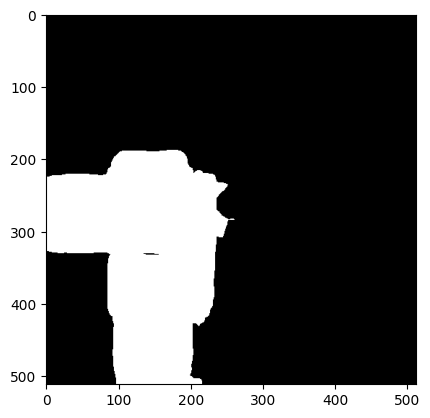

In [15]:
plt.imshow(train_predicted_masks[150][11], cmap='gray')

In [12]:
train_dice_score, test_dice_score = [],[]
for i in range (len(train_dice_loss)):
    train_dice_score.append(1-train_dice_loss[i])
    test_dice_score.append(1-test_dice_loss[i])

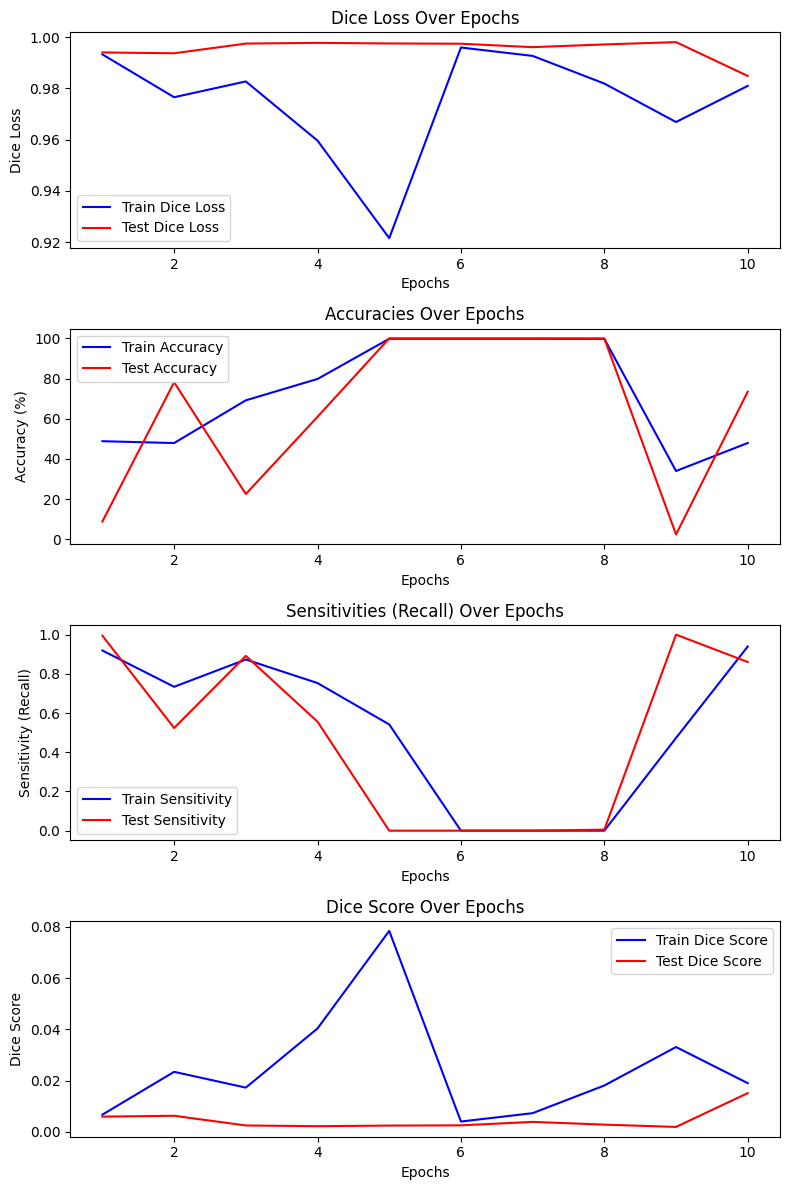

In [13]:
# Create subplots
fig, axs = plt.subplots(4, 1, figsize=(8, 12))

#nepochs = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

# Plot dice loss
axs[0].plot(nepochs, train_dice_loss, label="Train Dice Loss", color="b")
axs[0].plot(nepochs, test_dice_loss, label="Test Dice Loss", color="r")
axs[0].set_title("Dice Loss Over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Dice Loss")
axs[0].legend()

# Plot accuracies
axs[1].plot(nepochs, train_accuracy, label="Train Accuracy", color="b")
axs[1].plot(nepochs, test_accuracy, label="Test Accuracy", color="r")
axs[1].set_title("Accuracies Over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy (%)")
axs[1].legend()

# Plot sensitivities
axs[2].plot(nepochs, train_sensitivity, label="Train Sensitivity", color="b")
axs[2].plot(nepochs, test_sensitivity, label="Test Sensitivity", color="r")
axs[2].set_title("Sensitivities (Recall) Over Epochs")
axs[2].set_xlabel("Epochs")
axs[2].set_ylabel("Sensitivity (Recall)")
axs[2].legend()

# Plot dice score
axs[3].plot(nepochs, train_dice_score, label="Train Dice Score", color="b")
axs[3].plot(nepochs, test_dice_score, label="Test Dice Score", color="r")
axs[3].set_title("Dice Score Over Epochs")
axs[3].set_xlabel("Epochs")
axs[3].set_ylabel("Dice Score")
axs[3].legend()

# Adjust layout
plt.tight_layout()
plt.show()
